In [1]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pickle
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [2]:
%matplotlib inline
plt.ion()

In [3]:
# data frame to hold all data
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/pionProton/TrainingTree_PionProtonSeparation_RHC_Nov2023.root")["trainingTree"]

variables = (
    "isSignal",
    
    
    "trk_score",
    "trk_llr_pid_score",
    "trk_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk_daughters",
    "trk_end_spacepoints"


)

#variables = (
#    "isSignal",
#    "trk_llr_pid_score",
#    "trk2_llr_pid_score",
#    "trk3_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk2_bragg_mip_max",
#    "trk3_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk2_bragg_pion_max",
#    "trk3_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk2_dEdx_trunk_max",
#    "trk3_dEdx_trunk_max",
#    "trk_daughters",
#    "trk2_daughters",
#    "trk3_daughters",
#    "trk_end_spacepoints",
#    "trk2_end_spacepoints",
#    "trk3_end_spacepoints"
#)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
df = df.sample(frac=1).reset_index(drop=True)


In [4]:
print(df.shape) 
print(df.keys())
df.head()

(40028, 8)
Index(['isSignal', 'trk_score', 'trk_llr_pid_score', 'trk_bragg_mip_max',
       'trk_bragg_pion_max', 'trk_dEdx_trunk_max', 'trk_daughters',
       'trk_end_spacepoints'],
      dtype='object')


,isSignal,trk_score,trk_llr_pid_score,trk_bragg_mip_max,trk_bragg_pion_max,trk_dEdx_trunk_max,trk_daughters,trk_end_spacepoints
0,True,0.921315,0.795314,0.590620,0.610227,1.919776,0.0,44.0
1,True,0.879384,0.575465,0.409838,0.286989,1.988472,1.0,51.0
2,True,0.997600,0.955696,0.507049,0.404945,1.881126,0.0,37.0
3,True,0.910831,0.623809,0.446767,0.096976,1.267625,0.0,37.0
4,True,0.692490,0.568977,0.387526,0.149288,2.299319,0.0,47.0


In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna()
print(df.shape) 

(40028, 8)


In [6]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

0.5892956404351624


In [7]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [8]:
print(df_train.shape)
print(df_test.shape)

(28019, 8)
(12009, 8)


In [7]:
print((df.query('isSignal == 0')).shape[0])
print((df.query('isSignal == 1')).shape[0])

14842
25186


In [9]:
# convert to DMatrix format
missing_value = 9999
bdt_vars = {
    "trk_llr_pid_score",
    "trk_score",
    "trk_bragg_mip_max",
    "trk_bragg_pion_max",
    "trk_dEdx_trunk_max",
    "trk_daughters",
    "trk_end_spacepoints"
}

#bdt_vars = {
#    "trk_llr_pid_score",
#    "trk2_llr_pid_score",
#    "trk3_llr_pid_score",
#    "trk_bragg_mip_max",
#    "trk2_bragg_mip_max",
#    "trk3_bragg_mip_max",
#    "trk_bragg_pion_max",
#    "trk2_bragg_pion_max",
#    "trk3_bragg_pion_max",
#    "trk_dEdx_trunk_max",
#    "trk2_dEdx_trunk_max",
#    "trk3_dEdx_trunk_max",
#    "trk_daughters",
#    "trk2_daughters",
#    "trk3_daughters",
#    "trk_end_spacepoints",
#    "trk2_end_spacepoints",
#    "trk3_end_spacepoints"
#}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73583/2143600462.py:34: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73583/2143600462.py:35: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_73583/2143600462.py:36: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [15]:
# configuring XGBoost (David M)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta':0.03,
        'gamma':1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight, 
        'nthread' : 6}

#scale_pos_weight = total_negative_examples / total_positive_examples

num_round = 100
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [31]:
# HyperOpt, Aug 17
#{'colsample_bytree': 0.9269247371136144,
# 'eta': 0.24465520677342173,
# 'gamma': 1.904478619929104,
# 'max_depth': 5,
# 'min_child_weight': 8.687635218919873,
# 'subsample': 0.7153011194637764}
#250

# configuring XGBoost (Optimised values using HyperOpt)
#xgb_param = {'booster': 'dart',
#        'max_depth':5,
#        'eta': 0.24,
#        'gamma': 1.90,
#        'colsample_bytree': 0.93,
#        'min_child_weight': 8.69,
#        'subsample': 0.72,
#        'objective':'binary:logistic',
#        'tree_method':'hist',
#        'rate_drop': 0.1,
#        'skip_drop': 0.5,    
#        'scale_pos_weight': scale_weight,
#        'nthread' : 6,
#        'random_state': 27} #27}


# configuring XGBoost (Values adapted from HyperOpt optimisation, less fine-tuned)
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta': 0.05,
        'gamma': 0.75,
        'min_child_weight': 5.0,
        'subsample': 0.75,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,    
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 50} #27}


num_round = 200
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [32]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval = 50)

[0]	train-logloss:0.66986	test-logloss:0.67040	test_sig-logloss:0.67042	test_bkg-logloss:0.67036
[50]	train-logloss:0.37417	test-logloss:0.38863	test_sig-logloss:0.37558	test_bkg-logloss:0.41111
[100]	train-logloss:0.34416	test-logloss:0.36329	test_sig-logloss:0.34680	test_bkg-logloss:0.39168
[150]	train-logloss:0.33000	test-logloss:0.35337	test_sig-logloss:0.33559	test_bkg-logloss:0.38398
[199]	train-logloss:0.32272	test-logloss:0.34909	test_sig-logloss:0.33182	test_bkg-logloss:0.37883


In [36]:
# save pickle 
pickle.dump(bdt, open("protonPionBDT.pickle.dat", "wb"))

In [37]:
# load from pickle
bdt = pickle.load(open("protonPionBDT.pickle.dat", "rb"))

In [38]:
# save model file
bdt.save_model("bdt_pionProton.json")
bdt.save_model("bdt_pionProton.model")

In [39]:
bdt.dump_model("bdt_dump_pionProton.txt")

In [40]:
bdt.load_model("bdt_pionProton.model")

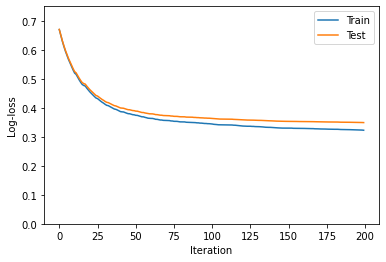

0.32272285340915785 0.3490939620504284


In [42]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.xlabel("Iteration")
plt.ylabel("Log-loss")
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])

#fig.savefig("training_rate_pionproton_rhc.pdf", format="pdf")

<Figure size 864x864 with 0 Axes>

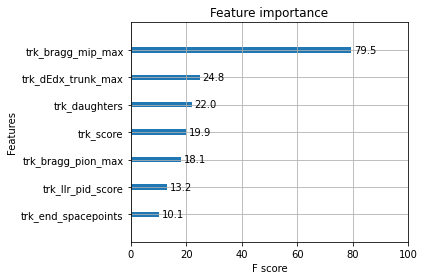

In [46]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(12,12),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=20,importance_type='gain')
plt.xlim(0, 100)
plt.tight_layout()
#plt.savefig("feature_importance_pionproton.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

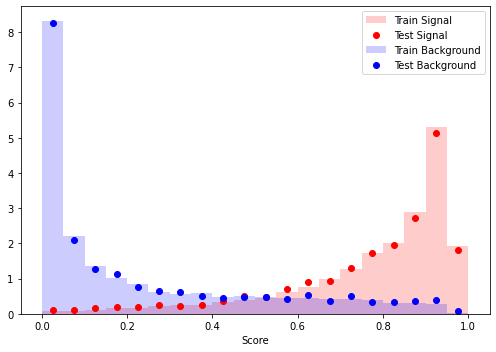

In [48]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_pionproton_rhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

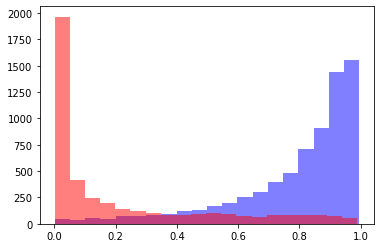

In [31]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

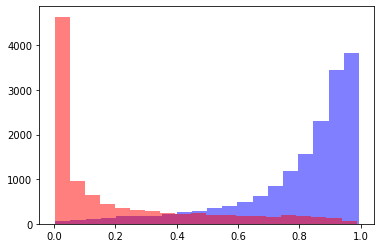

In [32]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

In [17]:
# Hyper parameter optimisation
# Un-tunded base case estimator to compare score
params_base = {'booster': 'dart',
               'objective': 'binary:logistic',
               'tree_method': 'hist',
               'rate_drop': 0.1,
               'skip_drop': 0.5,
               'scale_pos_weight': scale_weight,
               'random_state': 27}

base_model = xgb.train(params = params_base,
                       dtrain = xgb_train_dict,
                       num_boost_round = 300,
                       evals = [(xgb_test_dict,'eval')],
                       early_stopping_rounds=10,
                       verbose_eval = 20)

y_pred_base = base_model.predict(xgb_test_dict)

base_score = log_loss(df_test["isSignal"].values, y_pred_base)
print(base_score)

[0]	eval-logloss:0.56565
[20]	eval-logloss:0.33593
[40]	eval-logloss:0.33164
[48]	eval-logloss:0.33148
0.3314847248042098


In [18]:
# Simple Cross Val score as function to be optimised
def score(params):
    
    ps = {'eta': params['eta'],
         'max_depth': params['max_depth'], 
         'gamma': params['gamma'],
         'min_child_weight': params['min_child_weight'], 
         'subsample': params['subsample'], 
         'colsample_bytree': params['colsample_bytree'], 
         'verbosity': 1, 
         'objective': 'binary:logistic',
         'booster': 'dart',
         'eval_metric': 'logloss', 
         'tree_method': 'hist', 
         'rate_drop': 0.1,
         'skip_drop': 0.5,    
         'scale_pos_weight': scale_weight,
         'random_state': 27,
         }
    model = xgb.train(ps,xgb_train_dict, params['n_round'], [(xgb_test_dict, 'eval')], verbose_eval = False)
    y_pred = model.predict(xgb_test_dict)
    score = log_loss(df_test["isSignal"].values, y_pred)

    return score

In [19]:
# Define parameter space
param_space = {'eta': hp.uniform('eta', 0.01, 0.3), 
               'n_round': scope.int(hp.quniform('n_round', 100, 400, 50)),
               'max_depth': scope.int(hp.quniform('max_depth', 3, 5, 1)), 
               'gamma': hp.uniform('gamma', 0.5, 10), 
               'min_child_weight': hp.uniform('min_child_weight', 0.5, 10),
               'subsample': hp.uniform('subsample', 0.1, 1), 
               'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
              }


In [20]:
# Run optimiser with tpe
%time
trials = Trials()

hopt = fmin(fn = score,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 250, ## 100
            trials = trials, 
           )

params_best = hopt
params_best['max_depth'] = int(hopt['max_depth'])
n_rounds_best = int(hopt['n_round'])
del params_best['n_round']
print(params_best)
print(n_rounds_best)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.62 µs
  0%|                                                                                         | 0/250 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  0%|▏                                                           | 1/250 [00:35<2:26:40, 35.34s/trial, best loss: 0.35234286419494293]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▍                                                           | 2/250 [01:42<3:43:18, 54.03s/trial, best loss: 0.34890566172953824]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▋                                                           | 3/250 [02:43<3:55:48, 57.28s/trial, best loss: 0.34890566172953824]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|▉                                                            | 4/250 [03:22<3:25:31, 50.13s/trial, best loss: 0.3364336031500567]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▏                                                           | 5/250 [05:12<4:51:51, 71.48s/trial, best loss: 0.3364336031500567]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▍                                                           | 6/250 [06:24<4:51:40, 71.73s/trial, best loss: 0.3364336031500567]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|█▋                                                           | 7/250 [08:48<6:26:29, 95.43s/trial, best loss: 0.3364336031500567]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|█▉                                                           | 8/250 [09:57<5:51:00, 87.03s/trial, best loss: 0.3364336031500567]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▏                                                          | 9/250 [11:04<5:23:55, 80.64s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▎                                                        | 10/250 [14:21<7:46:55, 116.73s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▌                                                        | 11/250 [15:27<6:42:36, 101.07s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|██▉                                                         | 12/250 [16:29<5:54:23, 89.34s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|███                                                         | 13/250 [17:08<4:52:10, 73.97s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▎                                                        | 14/250 [19:34<6:16:52, 95.82s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▌                                                       | 15/250 [22:48<8:10:55, 125.34s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▊                                                       | 16/250 [25:09<8:26:43, 129.93s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████                                                       | 17/250 [25:44<6:34:09, 101.50s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████▏                                                      | 18/250 [28:59<8:21:25, 129.68s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▍                                                      | 19/250 [31:28<8:41:07, 135.36s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▋                                                      | 20/250 [34:48<9:53:10, 154.74s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▉                                                      | 21/250 [35:06<7:14:03, 113.73s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|█████▎                                                      | 22/250 [35:24<5:22:39, 84.91s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|█████▌                                                      | 23/250 [35:42<4:05:31, 64.90s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█████▊                                                      | 24/250 [37:30<4:53:06, 77.82s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|██████                                                      | 25/250 [39:11<5:18:19, 84.89s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|██████▏                                                     | 26/250 [40:56<5:39:54, 91.05s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|██████▍                                                     | 27/250 [42:40<5:52:46, 94.92s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|██████▌                                                    | 28/250 [46:48<8:40:39, 140.72s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|██████▊                                                    | 29/250 [47:27<6:45:22, 110.06s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|███████▏                                                    | 30/250 [48:06<5:25:33, 88.79s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|███████▍                                                    | 31/250 [48:44<4:28:17, 73.51s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████▋                                                    | 32/250 [49:00<3:25:16, 56.50s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████▉                                                    | 33/250 [49:38<3:03:52, 50.84s/trial, best loss: 0.3332279008609625]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████▏                                                   | 34/250 [50:51<3:26:38, 57.40s/trial, best loss: 0.3316823387498408]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████▍                                                   | 35/250 [51:59<3:37:36, 60.73s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████▋                                                   | 36/250 [53:08<3:45:21, 63.18s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|████████▉                                                   | 37/250 [54:17<3:50:20, 64.89s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|█████████                                                   | 38/250 [55:21<3:48:51, 64.77s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▎                                                  | 39/250 [57:00<4:23:10, 74.84s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▌                                                  | 40/250 [58:14<4:21:39, 74.76s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▌                                                | 41/250 [1:00:01<4:53:58, 84.39s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|█████████▋                                                | 42/250 [1:01:09<4:35:23, 79.44s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|█████████▊                                               | 43/250 [1:03:49<5:57:08, 103.52s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▏                                               | 44/250 [1:04:09<4:29:39, 78.54s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▍                                               | 45/250 [1:05:23<4:23:44, 77.19s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▋                                               | 46/250 [1:06:06<3:47:34, 66.94s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|██████████▉                                               | 47/250 [1:08:00<4:33:42, 80.90s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|██████████▉                                              | 48/250 [1:10:35<5:47:49, 103.32s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████▎                                              | 49/250 [1:11:17<4:44:30, 84.93s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████▌                                              | 50/250 [1:12:36<4:36:39, 83.00s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████▊                                              | 51/250 [1:13:24<4:00:44, 72.58s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|███████████▊                                             | 52/250 [1:18:18<7:38:53, 139.06s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|████████████                                             | 53/250 [1:18:37<5:37:41, 102.85s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|████████████▎                                            | 54/250 [1:20:25<5:41:35, 104.57s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|████████████▊                                             | 55/250 [1:21:36<5:07:01, 94.47s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|████████████▊                                            | 56/250 [1:24:28<6:20:17, 117.61s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|████████████▉                                            | 57/250 [1:28:20<8:08:44, 151.94s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|█████████████▏                                           | 58/250 [1:28:41<6:00:28, 112.65s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████▍                                           | 59/250 [1:29:56<5:22:39, 101.36s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████▋                                           | 60/250 [1:32:48<6:28:04, 122.55s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████▉                                           | 61/250 [1:34:44<6:20:17, 120.73s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████▍                                           | 62/250 [1:35:26<5:04:12, 97.09s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████▎                                          | 63/250 [1:37:17<5:15:44, 101.31s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████▊                                           | 64/250 [1:38:32<4:49:02, 93.24s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████                                           | 65/250 [1:39:15<4:01:09, 78.21s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|███████████████▎                                          | 66/250 [1:40:24<3:51:44, 75.57s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|███████████████▌                                          | 67/250 [1:41:35<3:46:14, 74.18s/trial, best loss: 0.3316505022666044]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|███████████████▌                                         | 68/250 [1:42:48<3:43:41, 73.75s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|███████████████▋                                         | 69/250 [1:44:01<3:41:38, 73.47s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|███████████████▉                                         | 70/250 [1:45:56<4:18:05, 86.03s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|████████████████▏                                        | 71/250 [1:46:38<3:36:52, 72.69s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|████████████████▍                                        | 72/250 [1:48:31<4:11:53, 84.91s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|████████████████▋                                        | 73/250 [1:48:50<3:12:19, 65.20s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████▊                                        | 74/250 [1:49:32<2:50:42, 58.20s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|█████████████████                                        | 75/250 [1:50:46<3:03:51, 63.04s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|█████████████████▎                                       | 76/250 [1:52:36<3:43:35, 77.10s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|█████████████████▌                                       | 77/250 [1:53:19<3:12:14, 66.67s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|█████████████████▊                                       | 78/250 [1:54:35<3:19:12, 69.49s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████                                       | 79/250 [1:55:45<3:19:06, 69.86s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████▏                                      | 80/250 [1:58:15<4:25:28, 93.69s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████▍                                      | 81/250 [1:58:34<3:21:17, 71.47s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|██████████████████▋                                      | 82/250 [2:00:22<3:50:24, 82.29s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|██████████████████▉                                      | 83/250 [2:01:02<3:13:31, 69.53s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████▏                                     | 84/250 [2:02:16<3:16:20, 70.97s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████▍                                     | 85/250 [2:04:06<3:47:29, 82.72s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████▌                                     | 86/250 [2:04:50<3:14:35, 71.19s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|███████████████████▍                                    | 87/250 [2:08:24<5:09:16, 113.84s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|███████████████████▋                                    | 88/250 [2:09:38<4:34:52, 101.81s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▎                                    | 89/250 [2:10:17<3:42:44, 83.01s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▏                                   | 90/250 [2:12:43<4:31:44, 101.90s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▍                                   | 91/250 [2:14:38<4:40:32, 105.86s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|████████████████████▉                                    | 92/250 [2:14:56<3:29:34, 79.59s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|████████████████████▊                                   | 93/250 [2:19:16<5:50:01, 133.77s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████                                   | 94/250 [2:20:30<5:00:37, 115.62s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████▎                                  | 95/250 [2:21:41<4:24:33, 102.41s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████▌                                  | 96/250 [2:24:13<5:01:10, 117.34s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|█████████████████████▋                                  | 97/250 [2:26:10<4:58:42, 117.14s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|██████████████████████▎                                  | 98/250 [2:26:34<3:45:48, 89.13s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▌                                  | 99/250 [2:27:34<3:22:47, 80.58s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▍                                 | 100/250 [2:28:44<3:12:55, 77.17s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▌                                 | 101/250 [2:30:33<3:35:50, 86.91s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|██████████████████████▊                                 | 102/250 [2:31:46<3:23:45, 82.61s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|███████████████████████                                 | 103/250 [2:32:28<2:52:49, 70.54s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▎                                | 104/250 [2:33:36<2:49:43, 69.75s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▌                                | 105/250 [2:35:25<3:16:37, 81.36s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▋                                | 106/250 [2:35:45<2:31:27, 63.11s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|███████████████████████▉                                | 107/250 [2:36:56<2:36:14, 65.56s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|████████████████████████▏                               | 108/250 [2:37:38<2:17:56, 58.29s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▍                               | 109/250 [2:40:19<3:29:45, 89.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▋                               | 110/250 [2:41:03<2:56:37, 75.69s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▊                               | 111/250 [2:43:01<3:24:17, 88.18s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|█████████████████████████                               | 112/250 [2:44:17<3:14:34, 84.60s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|█████████████████████████▎                              | 113/250 [2:45:02<2:46:16, 72.82s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▌                              | 114/250 [2:46:16<2:45:39, 73.09s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▊                              | 115/250 [2:46:36<2:08:51, 57.27s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▉                              | 116/250 [2:48:28<2:44:29, 73.66s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████▏                             | 117/250 [2:49:12<2:23:37, 64.79s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████▍                             | 118/250 [2:50:23<2:26:39, 66.66s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████▋                             | 119/250 [2:52:12<2:52:54, 79.19s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████▉                             | 120/250 [2:52:32<2:13:10, 61.47s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████▌                            | 121/250 [2:56:13<3:55:00, 109.31s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|███████████████████████████▎                            | 122/250 [2:56:56<3:11:05, 89.57s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|███████████████████████████▌                            | 123/250 [2:58:10<2:59:25, 84.77s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|███████████████████████████▎                           | 124/250 [3:00:43<3:41:10, 105.32s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|███████████████████████████▌                           | 125/250 [3:02:23<3:36:06, 103.73s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████▏                           | 126/250 [3:03:28<3:10:15, 92.06s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|███████████████████████████▉                           | 127/250 [3:05:58<3:44:34, 109.54s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|████████████████████████████▋                           | 128/250 [3:07:04<3:16:00, 96.40s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|████████████████████████████▉                           | 129/250 [3:08:20<3:01:51, 90.18s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████                           | 130/250 [3:08:40<2:18:17, 69.14s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████▎                          | 131/250 [3:11:09<3:04:51, 93.21s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████████████████████████████▌                          | 132/250 [3:12:16<2:47:40, 85.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████████████████████████████▊                          | 133/250 [3:12:57<2:20:42, 72.16s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████                          | 134/250 [3:14:50<2:42:44, 84.17s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████▏                         | 135/250 [3:15:30<2:16:22, 71.15s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████▍                         | 136/250 [3:18:15<3:08:31, 99.22s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|██████████████████████████████▋                         | 137/250 [3:19:30<2:53:03, 91.89s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|██████████████████████████████▎                        | 138/250 [3:22:54<3:54:28, 125.61s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|██████████████████████████████▌                        | 139/250 [3:24:38<3:40:33, 119.22s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████▎                        | 140/250 [3:24:57<2:43:21, 89.10s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████▌                        | 141/250 [3:26:10<2:32:58, 84.21s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|███████████████████████████████▊                        | 142/250 [3:26:52<2:08:40, 71.49s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|████████████████████████████████                        | 143/250 [3:27:34<1:51:32, 62.54s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▎                       | 144/250 [3:27:52<1:27:02, 49.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▍                       | 145/250 [3:28:10<1:09:56, 39.97s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▋                       | 146/250 [3:28:52<1:10:13, 40.51s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|████████████████████████████████▉                       | 147/250 [3:30:05<1:26:11, 50.21s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|█████████████████████████████████▏                      | 148/250 [3:30:46<1:20:52, 47.57s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▍                      | 149/250 [3:31:59<1:32:46, 55.11s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▌                      | 150/250 [3:32:39<1:24:35, 50.76s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▊                      | 151/250 [3:33:49<1:32:52, 56.29s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████████████████████████████████                      | 152/250 [3:34:59<1:38:41, 60.43s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████████████████████████████████▎                     | 153/250 [3:35:39<1:27:43, 54.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▍                     | 154/250 [3:36:47<1:33:29, 58.44s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▋                     | 155/250 [3:37:30<1:25:24, 53.94s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▉                     | 156/250 [3:37:49<1:07:58, 43.39s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|███████████████████████████████████▏                    | 157/250 [3:39:01<1:20:27, 51.91s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|███████████████████████████████████▍                    | 158/250 [3:39:43<1:14:58, 48.89s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████▌                    | 159/250 [3:41:35<1:43:11, 68.04s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████▊                    | 160/250 [3:42:49<1:44:22, 69.59s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|████████████████████████████████████                    | 161/250 [3:43:08<1:21:01, 54.62s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|████████████████████████████████████▎                   | 162/250 [3:44:21<1:28:03, 60.04s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|████████████████████████████████████▌                   | 163/250 [3:45:05<1:20:11, 55.30s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|████████████████████████████████████▋                   | 164/250 [3:46:58<1:44:00, 72.56s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|████████████████████████████████████▉                   | 165/250 [3:48:09<1:42:01, 72.02s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|█████████████████████████████████████▏                  | 166/250 [3:48:49<1:27:38, 62.60s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|█████████████████████████████████████▍                  | 167/250 [3:50:01<1:30:26, 65.38s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|█████████████████████████████████████▋                  | 168/250 [3:51:50<1:47:20, 78.55s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████▊                  | 169/250 [3:52:33<1:31:18, 67.64s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|██████████████████████████████████████                  | 170/250 [3:52:51<1:10:34, 52.93s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|██████████████████████████████████████▎                 | 171/250 [3:54:02<1:16:49, 58.35s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████▌                 | 172/250 [3:54:46<1:10:06, 53.93s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████▊                 | 173/250 [3:56:37<1:31:21, 71.19s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|██████████████████████████████████████▉                 | 174/250 [3:57:45<1:28:46, 70.08s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|██████████████████████████████████████▌                | 175/250 [4:02:33<2:49:20, 135.47s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|██████████████████████████████████████▋                | 176/250 [4:06:15<3:19:03, 161.40s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|██████████████████████████████████████▉                | 177/250 [4:06:36<2:25:15, 119.39s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|███████████████████████████████████████▏               | 178/250 [4:11:25<3:24:12, 170.18s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████▍               | 179/250 [4:15:00<3:37:14, 183.58s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████▌               | 180/250 [4:17:41<3:26:18, 176.83s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████▊               | 181/250 [4:21:23<3:39:09, 190.57s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|████████████████████████████████████████               | 182/250 [4:21:44<2:38:03, 139.46s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|████████████████████████████████████████▎              | 183/250 [4:24:22<2:42:09, 145.22s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▍              | 184/250 [4:25:08<2:06:47, 115.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▋              | 185/250 [4:30:03<3:03:23, 169.28s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▉              | 186/250 [4:33:43<3:16:51, 184.56s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|█████████████████████████████████████████▏             | 187/250 [4:38:22<3:43:35, 212.94s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|█████████████████████████████████████████▎             | 188/250 [4:43:20<4:06:20, 238.39s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|█████████████████████████████████████████▌             | 189/250 [4:48:12<4:18:44, 254.51s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|█████████████████████████████████████████▊             | 190/250 [4:53:00<4:24:28, 264.47s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|██████████████████████████████████████████             | 191/250 [4:58:02<4:31:00, 275.60s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|██████████████████████████████████████████▏            | 192/250 [5:03:06<4:34:41, 284.17s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|██████████████████████████████████████████▍            | 193/250 [5:06:53<4:13:52, 267.23s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|██████████████████████████████████████████▋            | 194/250 [5:11:44<4:16:02, 274.33s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|██████████████████████████████████████████▉            | 195/250 [5:16:20<4:11:43, 274.61s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|███████████████████████████████████████████            | 196/250 [5:20:00<3:52:27, 258.29s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|███████████████████████████████████████████▎           | 197/250 [5:24:49<3:56:16, 267.48s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|███████████████████████████████████████████▌           | 198/250 [5:28:41<3:42:40, 256.94s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|███████████████████████████████████████████▊           | 199/250 [5:33:34<3:47:32, 267.70s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|████████████████████████████████████████████           | 200/250 [5:37:11<3:30:32, 252.64s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|████████████████████████████████████████████▏          | 201/250 [5:42:00<3:35:01, 263.30s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|████████████████████████████████████████████▍          | 202/250 [5:46:53<3:37:54, 272.38s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|████████████████████████████████████████████▋          | 203/250 [5:51:43<3:37:26, 277.59s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████▉          | 204/250 [5:55:20<3:19:01, 259.59s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|█████████████████████████████████████████████          | 205/250 [5:59:08<3:07:26, 249.91s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|███████████████████████████████████████████▋         | 206/250 [7:18:37<19:37:35, 1605.80s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|███████████████████████████████████████████▉         | 207/250 [8:16:30<25:52:09, 2165.81s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|████████████████████████████████████████████         | 208/250 [9:09:32<28:49:35, 2470.86s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|████████████████████████████████████████████▎        | 209/250 [9:13:19<20:28:23, 1797.65s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|████████████████████████████████████████████▌        | 210/250 [9:13:39<14:02:49, 1264.24s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|██████████████████████████████████████████████▍        | 211/250 [9:13:58<9:38:57, 890.72s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|██████████████████████████████████████████████▋        | 212/250 [9:16:30<7:03:41, 668.99s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|████████████████████████████████████████████▎       | 213/250 [10:10:16<14:45:44, 1436.33s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|████████████████████████████████████████████▌       | 214/250 [10:10:59<10:10:59, 1018.32s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████▍       | 215/250 [10:14:30<7:32:39, 775.98s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████▋       | 216/250 [10:15:09<5:14:31, 555.04s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|██████████████████████████████████████████████▊       | 217/250 [10:15:29<3:36:57, 394.48s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|███████████████████████████████████████████████       | 218/250 [10:19:07<3:02:08, 341.50s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|█████████████████████████████████████████████▌      | 219/250 [11:11:46<10:13:04, 1186.60s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████▌      | 220/250 [11:14:18<7:18:06, 876.21s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████▋      | 221/250 [11:14:56<5:02:03, 624.93s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|███████████████████████████████████████████████▉      | 222/250 [11:15:15<3:26:42, 442.94s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|████████████████████████████████████████████████▏     | 223/250 [11:17:07<2:34:39, 343.67s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|████████████████████████████████████████████████▍     | 224/250 [11:46:36<5:34:13, 771.29s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|████████████████████████████████████████████████▌     | 225/250 [11:47:15<3:49:54, 551.80s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|████████████████████████████████████████████████▊     | 226/250 [11:57:27<3:47:51, 569.64s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|█████████████████████████████████████████████████     | 227/250 [11:58:11<2:37:55, 411.98s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|█████████████████████████████████████████████████▏    | 228/250 [11:59:18<1:53:11, 308.71s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|█████████████████████████████████████████████████▍    | 229/250 [12:02:45<1:37:20, 278.11s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|█████████████████████████████████████████████████▋    | 230/250 [12:04:43<1:16:43, 230.17s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|█████████████████████████████████████████████████▉    | 231/250 [12:09:32<1:18:28, 247.80s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|███████████████████████████████████████████████████▉    | 232/250 [12:09:51<53:42, 179.01s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|████████████████████████████████████████████████████▏   | 233/250 [12:11:03<41:38, 146.95s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|████████████████████████████████████████████████████▍   | 234/250 [12:11:44<30:44, 115.31s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████▌   | 235/250 [12:12:02<21:29, 85.94s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|████████████████████████████████████████████████████▊   | 236/250 [12:15:30<28:37, 122.68s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|█████████████████████████████████████████████████████   | 237/250 [12:16:37<22:56, 105.87s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|█████████████████████████████████████████████████████▎  | 238/250 [12:21:04<30:49, 154.16s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|█████████████████████████████████████████████████████▌  | 239/250 [12:23:00<26:11, 142.87s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|█████████████████████████████████████████████████████▊  | 240/250 [12:23:40<18:38, 111.80s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|██████████████████████████████████████████████████████▉  | 241/250 [12:24:49<14:51, 99.10s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|██████████████████████████████████████████████████████▏ | 242/250 [12:27:19<15:14, 114.26s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|██████████████████████████████████████████████████████▍ | 243/250 [12:31:48<18:46, 160.89s/trial, best loss: 0.33116641298564703]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████▋ | 244/250 [12:33:33<14:23, 143.96s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████▉ | 245/250 [12:35:14<10:55, 131.16s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|███████████████████████████████████████████████████████ | 246/250 [12:37:05<08:20, 125.07s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|███████████████████████████████████████████████████████▎| 247/250 [12:39:35<06:37, 132.65s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|███████████████████████████████████████████████████████▌| 248/250 [12:40:51<03:50, 115.49s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|████████████████████████████████████████████████████████▊| 249/250 [12:41:09<01:26, 86.19s/trial, best loss: 0.33025850538279916]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|████████████████████████████████████████████████████████| 250/250 [12:42:18<00:00, 182.95s/trial, best loss: 0.33025850538279916]
{'colsample_bytree': 0.9269247371136144, 'eta': 0.24465520677342173, 'gamma': 1.904478619929104, 'max_depth': 5, 'min_child_weight': 8.687635218919873, 'subsample': 0.7153011194637764}
250
